In [39]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [40]:
root_path = "/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final"
output_fig_path = '/Users/cdq/Desktop/opensource/FedPrompt/figs/overall'
# roberta-large
filenames_list = {
    "agnews": ["fedcls.log", 
    "ours.log",
    "ours+.log", "ours++.log",
    ],
    "mnli": ["fedcls.log", 
    "ours.log",
    "ours+.log", "ours++.log",
    ],
    "yahoo": ["fedcls.log", 
    "ours.log",
    "ours+.log", "ours++.log",
    ],
    "yelp-full": ["fedcls.log", 
    "ours.log",
    "ours+.log", "ours++.log",
    ],
}

datasets = {"agnews": 1,"mnli": 0, "yahoo": 5, "yelp-full": 0} # "agnews": 1, "mnli": 0, "yahoo": 5, "yelp-full": 0
all_client_num_in_total_list = {"agnews": 100, "yahoo": 1000, "yelp-full": 1000, "mnli": 1000}
alphas = {"agnews": 1, "yahoo": 0, "yelp-full": 0, "mnli": 0}
gammas = {"agnews": 0.001, "yahoo": 0.001, "yelp-full": 0.001, "mnli": 100}
seed = 99
# plot hyper-para.
colors=['r','g','b','y','c','m','k'] * 100
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}

# # TX2: Real per batch latency, bs = 4, msl = 256.
# train_latency_list = {"tx2+bitfit": 1 , "tx2+full": 2}
# infer_latency_list = {"tx2+bitfit": 0.5, "tx2+full": 1 }
# communication_latency_list = {"bitfit": 1000 * 2 / 1000 / 1, "full": 1000 * 2 / 1}

# RPI: Fake per batch latency, bs = 4, msl = 256. latency = tx2 * 15 
train_latency_list = {"tx2+bitfit": 1 * 15, "tx2+full": 2 * 15}
infer_latency_list = {"tx2+bitfit": 0.5 * 15, "tx2+full": 1 *15 }
communication_latency_list = {"bitfit": 1000 * 2 / 1000 / 1, "full": 1000 * 2 / 1}

# # TX2: Real per batch latency, bs = 4, msl = 256. copied from fedfinetuning.
comp_watts = 12
comm_watts = 4

labels = ["FedCLS", "Ours", "Ours+", "Ours++"]

In [41]:
# plot hyper-para.
colors=['r','g', 'b','y','c','m','k'] * 100
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}

40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0
40000.0


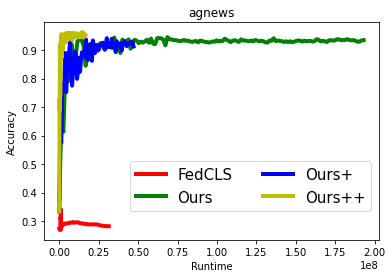

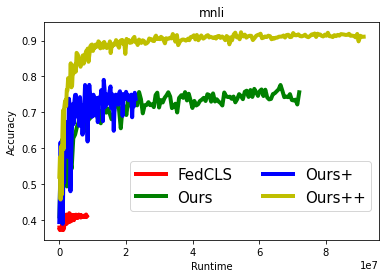

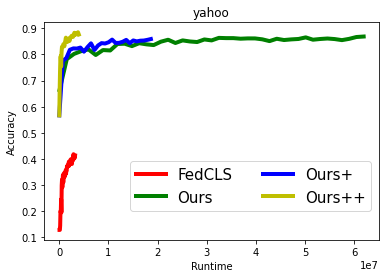

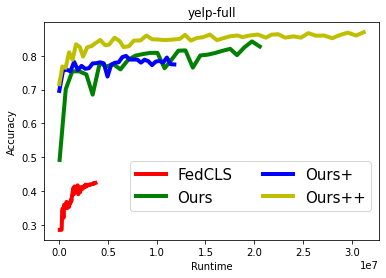

In [42]:
# energy ,time * watt
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     

for dataset in filenames_list:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                if filenames.index(filename) <= 1:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+full"] * comp_watts
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+full"] * comp_watts
                else:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+bitfit"] * comp_watts
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+bitfit"] * comp_watts
                
                if filenames.index(filename) <= 1:
                    comm_time = communication_latency_list["full"] * 5 * comm_watts
                else:
                    comm_time = communication_latency_list["bitfit"] * 5 * comm_watts
                print(comm_time)
                time_stamp = time_stamp + train_time + infer_time + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")
    
        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        runtime_list[dataset].append(runtime[idx])
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = len(df.index)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    # fig.savefig(os.path.join(output_fig_path, f"{dataset}-11.30-time2accuracy.pdf"))

In [43]:
runtime_list

{'agnews': [1008640.0, 68571720.0, 30123880.0, 14749530.0],
 'mnli': [3003000.0, 66398820.0, 13341590.0, 54540420.0],
 'yahoo': [2899840.0, 61873840.0, 18624420.0, 3812320.0],
 'yelp-full': [3719360.0, 19767280.0, 6860380.0, 31220200.0]}

10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0


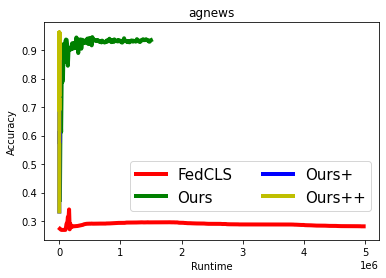

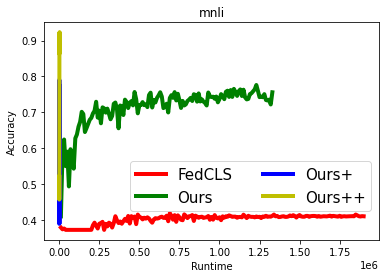

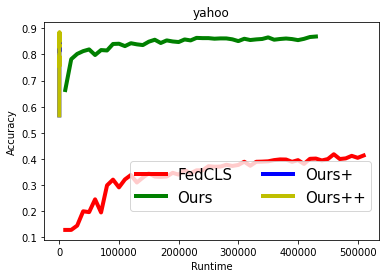

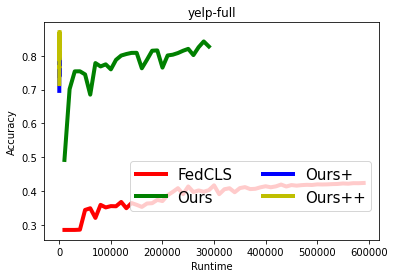

In [44]:
# 只计算 comm的时间，这样算出来的就是comm. cost了
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     

for dataset in filenames_list:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                if filenames.index(filename) <= 1:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+full"] * comp_watts
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+full"] * comp_watts
                else:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+bitfit"] * comp_watts
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+bitfit"] * comp_watts
                
                if filenames.index(filename) <= 1:
                    comm_time = communication_latency_list["full"] * 5
                else:
                    comm_time = communication_latency_list["bitfit"] * 5
                print(comm_time)
                time_stamp = time_stamp + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")
    
        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        runtime_list[dataset].append(runtime[idx])
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = len(df.index)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    # fig.savefig(os.path.join(output_fig_path, f"{dataset}-11.30-time2accuracy.pdf"))

In [45]:
runtime_list

{'agnews': [160000.0, 540000.0, 490.0, 1050.0],
 'mnli': [690000.0, 1230000.0, 560.0, 1680.0],
 'yahoo': [460000.0, 430000.0, 270.0, 340.0],
 'yelp-full': [590000.0, 280000.0, 190.0, 520.0]}

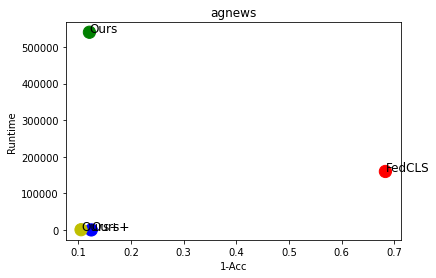

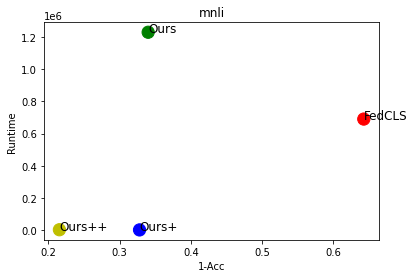

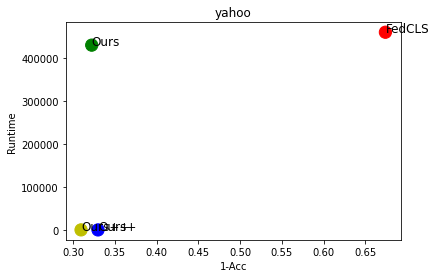

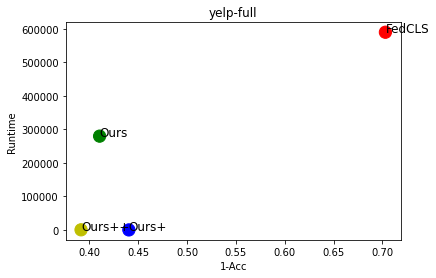

In [46]:
c=0
for dataset in datasets:
    fig = plt.figure()
    plt.title(f"{dataset}")
    plt.xlabel("1-Acc")
    plt.ylabel("Runtime")
    plt.scatter(1- np.array(acc_list[dataset]), np.array(runtime_list[dataset]),s=150,color=colors[:len(acc_list[dataset])])
    for idx in range(len(acc_list[dataset])):
        plt.text(1-acc_list[dataset][idx], runtime_list[dataset][idx], labels[idx], fontsize=12)
    plt.savefig(os.path.join(output_fig_path, f"sactter-{dataset}.pdf"))
    c=c+1

In [47]:
runtime_list

{'agnews': [160000.0, 540000.0, 490.0, 1050.0],
 'mnli': [690000.0, 1230000.0, 560.0, 1680.0],
 'yahoo': [460000.0, 430000.0, 270.0, 340.0],
 'yelp-full': [590000.0, 280000.0, 190.0, 520.0]}

/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/fedcls.log
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/ours.log
0.1625431325815517
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/ours+.log
0.16284741718135878
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/ours++.log
1.6646689374667645
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/mnli/all_1000/seed_99/pattern_0/alpha_0_beta_0_gamma_100/fedcls.log
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/mnli/all_1000/seed_99/pattern_0/alpha_0_beta_0_gamma_100/ours.log
0.42845742527689856
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/mnli/all_1

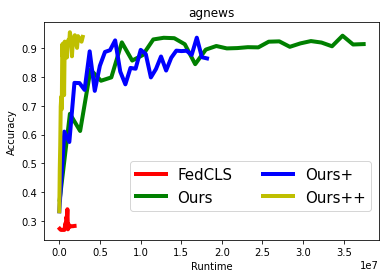

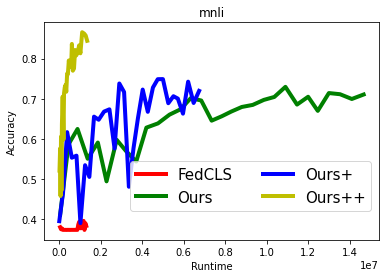

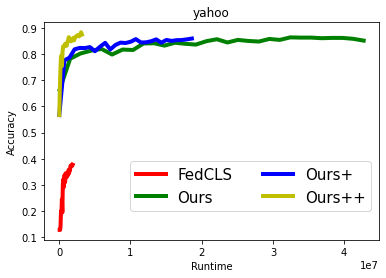

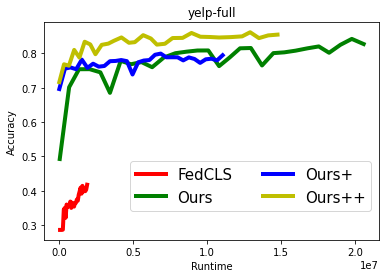

In [48]:
# energy to accuracy  take acc of threshold as the final acc
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     

acc_threshold_list = {"agnews": 0.9, "mnli": 0.72, "yahoo": 0.85, "yelp-full": 0.79}
for dataset in filenames_list:
    acc_threshold = acc_threshold_list[dataset]
    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                if filenames.index(filename) <= 1:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+full"] * comp_watts
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+full"] * comp_watts
                else:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+bitfit"] * comp_watts
                    if dataset == "mnli" and filenames.index(filename) == 3:
                        infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+bitfit"] * comp_watts / 10
                    else:
                        infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+bitfit"] * comp_watts
                
                if filenames.index(filename) <= 1:
                    comm_time = communication_latency_list["full"] * 5 * comm_watts
                else:
                    comm_time = communication_latency_list["bitfit"] * 5 * comm_watts
                # print(comm_time)
                time_stamp = time_stamp + train_time + infer_time + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")
    
        this_max_acc = np.max(df[0])
        
        print(log_path)
        if infer_runtime[-1] > 0:
            print(train_runtime[-1]/infer_runtime[-1])
        # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        if this_max_acc >= full_set_acc[dataset] * acc_threshold:
            idx = [df[0].to_list().index(x) for x in df[0] if x > full_set_acc[dataset] * acc_threshold][0]
            runtime_list[dataset].append(runtime[idx])
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = min(len(df.index),30)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        # print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    # fig.savefig(os.path.join(output_fig_path, f"{dataset}-11.30-time2accuracy.pdf"))

In [49]:
runtime_list

{'agnews': [7705000.0, 6881880.0, 382060.0],
 'mnli': [10896320.0, 2892980.0, 264280.0],
 'yahoo': [22139560.0, 10750600.0, 1247820.0],
 'yelp-full': [7855680.0, 6479640.0, 1017340.0]}

/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/fedcls.log
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/ours.log
0.1625431325815517
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/ours+.log
0.16284741718135878
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/agnews/all_100/seed_99/pattern_1/alpha_1_beta_0_gamma_0.001/ours++.log
1.6646689374667645
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/mnli/all_1000/seed_99/pattern_0/alpha_0_beta_0_gamma_100/fedcls.log
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/mnli/all_1000/seed_99/pattern_0/alpha_0_beta_0_gamma_100/ours.log
0.42845742527689856
/Users/cdq/Desktop/opensource/FedPrompt/data/overall-performance/final/mnli/all_1

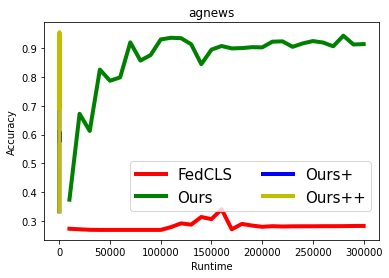

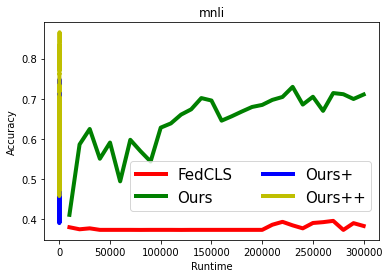

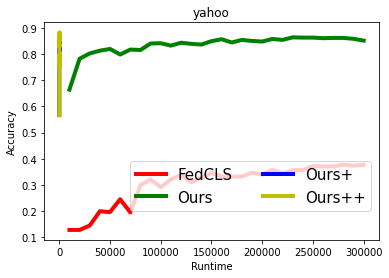

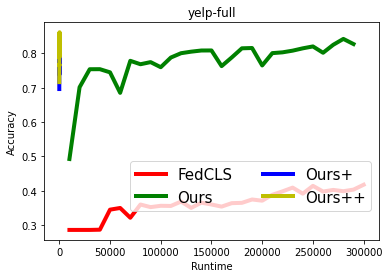

In [50]:
# network to accuracy  take acc of threshold as the final acc
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     

acc_threshold_list = {"agnews": 0.9, "mnli": 0.72, "yahoo": 0.85, "yelp-full": 0.79}
for dataset in filenames_list:
    acc_threshold = acc_threshold_list[dataset]
    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                if filenames.index(filename) <= 1:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+full"] * comp_watts
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+full"] * comp_watts
                else:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+bitfit"] * comp_watts
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+bitfit"] * comp_watts
                
                if filenames.index(filename) <= 1:
                    comm_time = communication_latency_list["full"] * 5
                else:
                    comm_time = communication_latency_list["bitfit"] * 5
                # print(comm_time)
                time_stamp = time_stamp + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")
    
        this_max_acc = np.max(df[0])
        
        print(log_path)
        if infer_runtime[-1] > 0:
            print(train_runtime[-1]/infer_runtime[-1])
        # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        if this_max_acc >= full_set_acc[dataset] * acc_threshold:
            idx = [df[0].to_list().index(x) for x in df[0] if x > full_set_acc[dataset] * acc_threshold][0]
            runtime_list[dataset].append(runtime[idx])
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = min(len(df.index),30)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        # print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    # fig.savefig(os.path.join(output_fig_path, f"{dataset}-11.30-time2accuracy.pdf"))

In [51]:
runtime_list

{'agnews': [70000.0, 120.0, 70.0],
 'mnli': [230000.0, 140.0, 100.0],
 'yahoo': [160000.0, 160.0, 150.0],
 'yelp-full': [120000.0, 180.0, 40.0]}